#**Projet - Régression logistique**

But : implémenter la régression logistique et mettre en oeuvre une méthodologie solide

Cours : M1 MIAGE apprentissage (Dauphine) - 2023-2024

Projet en binôme

A rendre :
*   Code ayant permis de résoudre les différentes questions (Notebook Python) - commenté pour permettre son exécution
*   Rapport en PDF (moins de 20 pages)

Date : le 01/12/2023 (avant 20h - heure de Paris)

In [18]:
# libairies utiles pour ce cours

# jeu de données
import sklearn as sk
from sklearn import datasets, model_selection

# calcul numériques (calculs d'estimateurs)
import numpy as np

#figures et illustrations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [19]:
#generation de données
n=100
rng = np.random.RandomState(2)
X,y = sk.datasets.make_classification(n_samples=n, n_features=2, n_redundant=0, n_informative=2, n_repeated=0, n_clusters_per_class=1, random_state=rng)

dim =2

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=.2, random_state=42)

Xb=np.column_stack((X_train,np.ones(X_train.shape[0])))
Xtb=np.column_stack((X_test,np.ones(X_test.shape[0])))

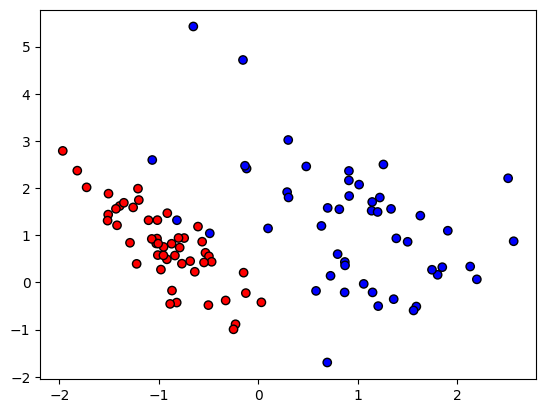

In [20]:
figure = plt.figure()
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright,edgecolors='k')

## I Regression logistique (8pts)

1. En vous appuyant sur le code écrit pour le TP 2 (notamment la descente de gradient), implémenter la régression logistique (2pts)

  /!\ /!\  *il faudra modifier le code ou le problème d'optimisation car dans le TP2, on minimisait une fonction et là, on maximise une fonction* /!\ /!\
2. Calculer $\beta$, les paramètres de la frontière de décision (1 pt)
8. prédire la classe du point $x = \left( \begin{array}{c}
0 \\
0 \end{array} \right)$ (1 pt)
9. Représenter la frontière de décision (en ré-utilisant le code écrit pour le TP 1) (1pt)
10. Développer une fonction de calcul de taux d'erreur d'un modèle. Appliquer ce code pour estimer le taux d'erreur (en apprentissage et en test) de votre modèle de régression logistique. (1pt)
11. Comparer ces résultats (frontière de décisions et taux d'erreurs) à ceux obtenus sur ces données par votre code de LDA (développé pour le TP 1) - commenter (2 pts)

In [21]:
def sigmoid(beta, x):
    return 1/(1+np.exp(-np.dot(x,beta)))

Itération 1000, Négative Loss: 0.09128695153758061
Itération 2000, Négative Loss: 0.0818445660994665
Itération 3000, Négative Loss: 0.07800427508290375
Itération 4000, Négative Loss: 0.07572505162301231
Itération 5000, Négative Loss: 0.07414515705600297
Itération 6000, Négative Loss: 0.07295608669673256
Itération 7000, Négative Loss: 0.07201538600897728
Itération 8000, Négative Loss: 0.07124619591200987
Itération 9000, Négative Loss: 0.07060242911078904
Itération 10000, Négative Loss: 0.07005426394946086
Paramètre finale : 
 [[7.08363439]
 [2.82820582]
 [0.18968043]]


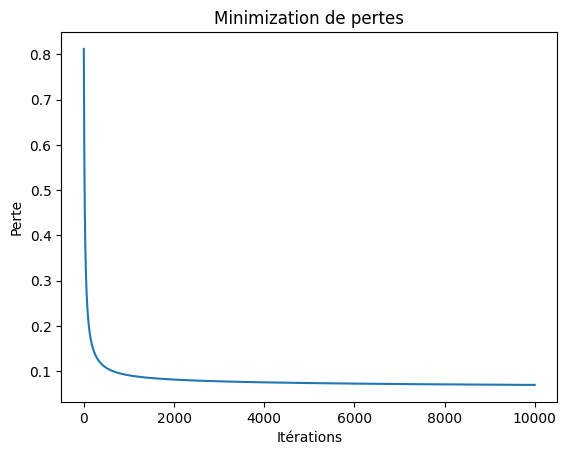

In [22]:
# descente de gradient
def gradient_descent(Xb, y_train, eta=1e-3, itermax=10000, epsilon=1e-8):
    dim = Xb.shape[1] - 1  # dimension de l'échantillon en enlevant la colonne de 1 (bias)
    beta = np.random.normal(size=(dim+1, 1))
    i = 1
    loss = []  # calcul de la fonction cout à chaque iteration
    loss_old = np.inf # ici -np.inf pour maximiser la fonction de perte, np.inf pour minimiser
    y_train = y_train.reshape(-1, 1)
    while(i <= itermax):
        beta_old = beta

        # Prédiction
        preds = sigmoid(beta, Xb)

        # Calcul du gradient
        # pour minization : 
        # grad = Xb.T @ (preds - y_train)
        grad = Xb.T @ (preds - y_train)

        # mise à jour le paramètre de l'hyperplan de l'itéré courant
        beta = beta_old - eta * grad # ajoute du gradient pour maximiser, soustrait pour minimiser

        # Calcul de la fonction de perte
        # pour minization : 
        # loss_new = - np.mean(y_train * np.log(preds) + (1 - y_train) * np.log(1 - preds))
        loss_new = - np.mean(y_train * np.log(preds) + (1 - y_train) * np.log(1 - preds))

        loss.append(loss_new)  # Append loss to the list

        # Critère de stabilité
        if np.linalg.norm(beta_old - beta) < epsilon: # inverse de minisization
            print("diff iterate")
            break

        # Critère de performance 
        if loss_new > loss_old: # inverse de minisization
            print("decreasing loss")
            break

        i += 1 
        loss_old = loss_new 

        if i % 1000 == 0:
            print(f"Itération {i}, Négative Loss: {loss_new}")
        
    return beta, loss

beta, loss = gradient_descent(Xb, y_train)
print("Paramètre finale : \n", beta)
plt.plot(loss)
plt.title("Minimization de pertes")
plt.xlabel("Itérations")
plt.ylabel("Perte")
plt.show()


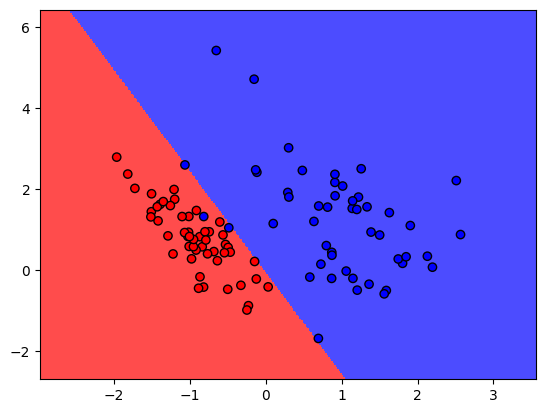

In [23]:
# frontière de décision
def decision_boundary(beta, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = .02

    xlim = np.arange(x_min, x_max, h)
    ylim = np.arange(y_min, y_max, h)

    xx, yy = np.meshgrid(xlim, ylim)

    # ajouter une colonne de 1 pour le biais
    Xtest = np.column_stack((xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape[0])))
    ypred = sigmoid(beta, Xtest)
    ypred = ypred.reshape(xx.shape)

    figure = plt.figure()
    plt.pcolormesh(xx, yy, ypred, cmap=cm_bright, shading='auto', alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright,edgecolors='k')

decision_boundary(beta, X, y)

In [24]:
class LogisticRegression:
    def __init__(self, eta=1e-3, itermax=10000, epsilon=1e-10):
        # pas d'apprentissage
        self.eta = eta
        # nombre d'itérations maximum
        self.itermax = itermax
        # critère d'arrêt
        self.epsilon = epsilon
        # paramètre de l'hyperplan
        self.beta = None
        # historique de la fonction de perte
        self.loss = []

    # Fonction d'apprentissage
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-np.dot(X, self.beta)))

    # Descente de gradient
    def fit(self, X, y):
        Xb = np.column_stack((X, np.ones((X.shape[0], 1))))  # Add bias term
        dim = Xb.shape[1] - 1
        self.beta = np.random.normal(size=(dim+1, 1))
        y = y.reshape(-1, 1)
        loss_old = np.inf

        for i in range(1, self.itermax + 1):
            preds = self.sigmoid(Xb)
            grad = Xb.T @ (preds - y)
            beta_old = self.beta
            self.beta = beta_old - self.eta * grad
            loss_new = -np.mean(y * np.log(preds) + (1 - y) * np.log(1 - preds))
            self.loss.append(loss_new)

            if np.linalg.norm(beta_old - self.beta) < self.epsilon:
                print("Convergence achieved at iteration", i)
                break

            if loss_new > loss_old:
                print("Loss increasing at iteration", i)
                break

            loss_old = loss_new

    # Prédiction
    def predict(self, X):
        Xb = np.column_stack((X, np.ones((X.shape[0], 1))))
        proba = self.sigmoid(Xb)
        return (proba >= 0.5).astype(int)

    def decision_boundary(self, X, y, feature_pair=(0, 1), fixed_features=None):
        # Extract the two features for plotting
        x_index, y_index = feature_pair
        x_min, x_max = X[:, x_index].min() - .5, X[:, x_index].max() + .5
        y_min, y_max = X[:, y_index].min() - .5, X[:, y_index].max() + .5
        h = .02  # step size in the mesh

        xlim = np.arange(x_min, x_max, h)
        ylim = np.arange(y_min, y_max, h)

        xx, yy = np.meshgrid(xlim, ylim)

        if fixed_features is not None:
            # Ensure the fixed features are correctly sized
            assert len(fixed_features) == X.shape[1] - 2, "Length of fixed_features should be num_features - 2"

            # Create a test dataset with the grid points and fixed features
            Xtest = np.column_stack([xx.ravel(), yy.ravel()] + fixed_features)
        else:
            Xtest = np.column_stack((xx.ravel(), yy.ravel()))

        # Insert the selected features in the correct columns
        temp_Xtest = np.zeros((Xtest.shape[0], X.shape[1]))
        temp_Xtest[:, [x_index, y_index]] = Xtest[:, [0, 1]]
        if fixed_features is not None:
            mask = np.ones(X.shape[1], np.bool)
            mask[[x_index, y_index]] = 0
            temp_Xtest[:, mask] = fixed_features

        temp_Xtest = np.column_stack((temp_Xtest, np.ones(temp_Xtest.shape[0])))
        # Predict
        ypred = self.sigmoid(temp_Xtest)
        ypred = ypred.reshape(xx.shape)

        # Plotting
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])
        plt.figure()
        plt.pcolormesh(xx, yy, ypred, cmap=cm_bright, shading='auto', alpha=0.7)
        plt.scatter(X[:, x_index], X[:, y_index], c=y, cmap=cm_bright, edgecolors='k')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xlabel(f"Feature {x_index}")
        plt.ylabel(f"Feature {y_index}")
        plt.title("Decision Boundary for Logistic Regression")
        plt.show()
    
    def error_rate(self, y, x):
        ypred = self.predict(x)
        error = np.mean(y != ypred.ravel()) * 100
        return f"{error:.2f}%"
    

In [25]:
# Implémentation de la LDA du TP1
class LinearDiscriminantAnalysis:
    def __init__(self):
        self.w = None
        self.b = None

    def fit(self, X, y):
        # Calcule les moyennes de chaque classe
        mu_0 = np.mean(X[y == 0], axis=0)
        mu_1 = np.mean(X[y == 1], axis=0)

        # Calcule les probabilités a priori
        pi_0 = np.mean(y == 0)
        pi_1 = np.mean(y == 1)

        # Calcule la matrice de covariance
        Xtemp = np.concatenate((X[y == 0, :] - mu_0, X[y == 1, :] - mu_1), axis=0)
        Sigma = (Xtemp.T @ Xtemp) / len(Xtemp)

        # Calcule l'inverse de la matrice de covariance
        iSigma = np.linalg.inv(Sigma)

        # Calcule les paramètres de l'hyperplan
        self.w = iSigma @ (mu_0 - mu_1)
        self.b = -0.5 * np.dot(np.dot((mu_0 - mu_1).T, iSigma), (mu_0 + mu_1)) + np.log(pi_0 / pi_1)

    # Prédit la classe de chaque échantillon
    def predict(self, X):
        return 0.5 + 0.5 * np.sign(-(X @ self.w + self.b))

    def decision_boundary(self, X, y):
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        h = .02

        xlim = np.arange(x_min, x_max, h)
        ylim = np.arange(y_min, y_max, h)

        xx, yy = np.meshgrid(xlim, ylim)

        Xtest = np.concatenate((np.reshape(xx, (np.size(xx), 1)), np.reshape(yy, (np.size(yy), 1))), axis=1)
        ypred = self.predict(Xtest)
        ypred = ypred.reshape(xx.shape)

        plt.figure()
        plt.pcolormesh(xx, yy, ypred, cmap=cm_bright, shading='auto', alpha=0.7)
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')
        plt.title("Frontière de décision LDA")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.show()

    def error_rate(self, y, x):
        ypred = self.predict(x)
        error = np.mean(y != ypred.ravel()) * 100
        return f"{error:.2f}%"

Taux d'erreur LDA sur l'échantillon de l'apprentissage :  3.75%
Taux d'erreur LDA sur l'échantillon du test :  5.00%


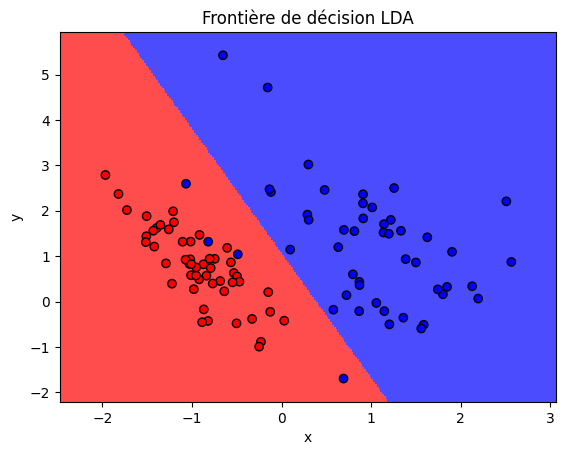

Taux d'erreur Logistic Regression sur l'échantillon de l'apprentissage :  2.50%
Taux d'erreur Logistic Regression sur l'échantillon du test :  5.00%


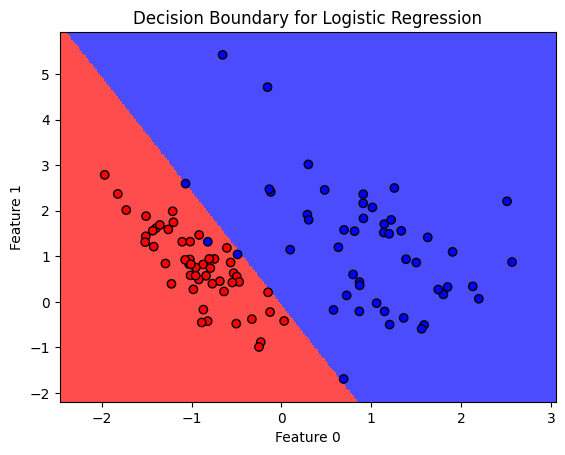

Prédiction de la classe de x :  [[1]]


In [26]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)
print("Taux d'erreur LDA sur l'échantillon de l'apprentissage : ",lda.error_rate(y_train,X_train))
print("Taux d'erreur LDA sur l'échantillon du test : ",lda.error_rate(y_test,X_test))
lda.decision_boundary(X, y)


logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)
print("Taux d'erreur Logistic Regression sur l'échantillon de l'apprentissage : ",logreg.error_rate(y_train,X_train))
print("Taux d'erreur Logistic Regression sur l'échantillon du test : ",logreg.error_rate(y_test,X_test))
logreg.decision_boundary(X, y)

# Prédition de x
x = np.array([[0,0]])
print("Prédiction de la classe de x : ",logreg.predict(x.reshape(1,-1)))


*Commentaire :*\
*Performance du modèle : Les deux modèles ont un faible taux d'erreur, ce qui suggère qu'ils sont performants sur cet ensemble de données particulier. Un taux d'erreur de 0,05 signifie que les deux modèles classent correctement 95 % des données testées.*

*Frontière de décision : les frontières de décision se ressemblent beaucoup, ce qui n'est pas surprenant étant donné que LDA et LR sont tous deux des modèles linéaires.*

## II Méthodologie (5pts)

7. inclure une ligne permettant d'ajouter un outlier dans les données d'apprentissage (ligne commentée dans le bloc de génération de données).
Comparez les résultats de vos codes de régression logistique et de LDA sur ces données. Commenter (1pt)

Taux d'erreur LDA sur l'échantillon de l'apprentissage :  5.00%
Taux d'erreur LDA sur l'échantillon du test :  5.00%


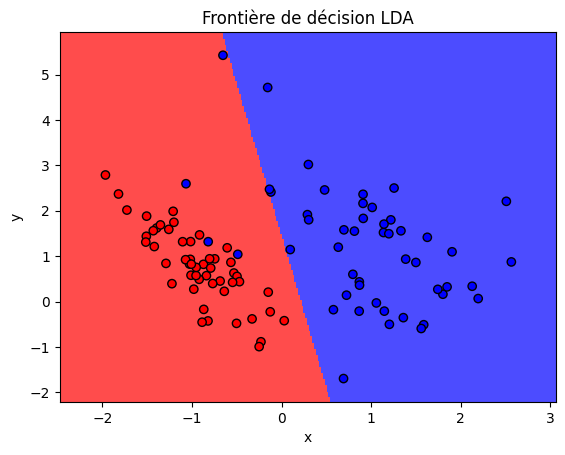

Loss increasing at iteration 1864
Taux d'erreur Logistic Regression sur l'échantillon de l'apprentissage :  3.75%
Taux d'erreur Logistic Regression sur l'échantillon du test :  5.00%


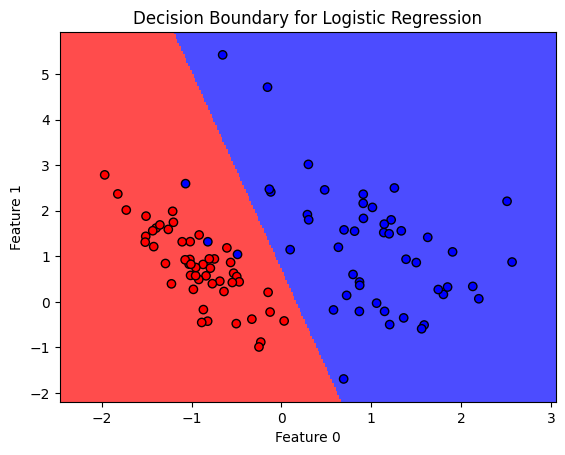

Prédiction de la classe de x :  [[0]]


In [27]:
# inclure cette ligne pour la question II.7
X_train[0,:] = [5,5]

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)
print("Taux d'erreur LDA sur l'échantillon de l'apprentissage : ",lda.error_rate(y_train,X_train))
print("Taux d'erreur LDA sur l'échantillon du test : ",lda.error_rate(y_test,X_test))
lda.decision_boundary(X, y)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)
print("Taux d'erreur Logistic Regression sur l'échantillon de l'apprentissage : ",logreg.error_rate(y_train,X_train))
print("Taux d'erreur Logistic Regression sur l'échantillon du test : ",logreg.error_rate(y_test,X_test))
logreg.decision_boundary(X, y)
print("Prédiction de la classe de x : ",logreg.predict(x.reshape(1,-1)))

*Commentaire :*\
*La descente de gradient s'arrête plus tôt quand le gradient ne change plus significativement, autrement dit on arrive à convergence du gradient. La frontère de décision est plus adaptée sur le graphique. LDA et LR ont bien résisté à l'inclusion d'une valeur aberrante, sans impact sur le taux d'erreur. LDA et LR se sont montrés peu sensibles à la perturbation, suggérant une bonne stabilité des modèles.*

<hr>
<p>
8. en plus des taux d'erreurs en apprentissage et en test, appliquer une statégie de validation croisée à n blocs et reporter les taux d'erreur (moyenne et variance) des deux modèles. (2pts)

In [28]:
# Validation croisée à n blocs
def leave_one_out_cross_validation(X, y, model):
    error_count = 0  # Initialize error counter
    n_samples = X.shape[0]  # Number of samples

    # Itération sur n blocs
    for i in range(n_samples):
        # Extraction i-ème bloc pour chaque itération
        X_train = np.concatenate((X[:i], X[(i + 1):]), axis=0)
        y_train = np.concatenate((y[:i], y[(i + 1):]), axis=0)
        X_test = X[i:i+1]
        y_test = y[i:i+1]

        # Apprentissage du modèle
        model.fit(X_train, y_train)

        # Prédiction
        y_pred = model.predict(X_test)

        # Calcul du taux d'erreur
        error_count += int(y_pred != y_test.ravel())

    # Calculate the error rate
    error_rate_mean = np.mean(error_count/n_samples)
    error_rate_var = np.var(error_count/n_samples)

    return error_rate_mean, error_rate_var

# Validation croisée à n blocs pour la LDA
lda = LinearDiscriminantAnalysis()
error_rate_mean, error_rate_var = leave_one_out_cross_validation(X, y, lda)
print("Moyen de taux d'erreur de la LDA : ", error_rate_mean*100, "%")
print("Variance du taux d'erreur de la LDA : ", error_rate_var*100, "%")

# Validation croisée à n blocs pour la régression logistique
logreg = LogisticRegression()
error_rate_mean, error_rate_var = leave_one_out_cross_validation(X, y, logreg)
print("Moyen de taux d'erreur de la régression logistique : ", error_rate_mean*100, "%")
print("Variance du taux d'erreur de la régression logistique : ", error_rate_var*100, "%")

Moyen de taux d'erreur de la LDA :  4.0 %
Variance du taux d'erreur de la LDA :  0.0 %
Moyen de taux d'erreur de la régression logistique :  4.0 %
Variance du taux d'erreur de la régression logistique :  0.0 %


<hr>
<p>
9. modifier le code de génération de données (en augmentant le nombre de dimensions et en ajoutant des variables correlées). Comparer le comportement des deux modèles (2pts)      *(on commentera à nouveau la ligne de génération d'outlier pour cette question)*

Taux d'erreur LDA sur l'échantillon de test :  5.00%
Taux d'erreur Logistic Regression sur l'échantillon de test :  5.00%


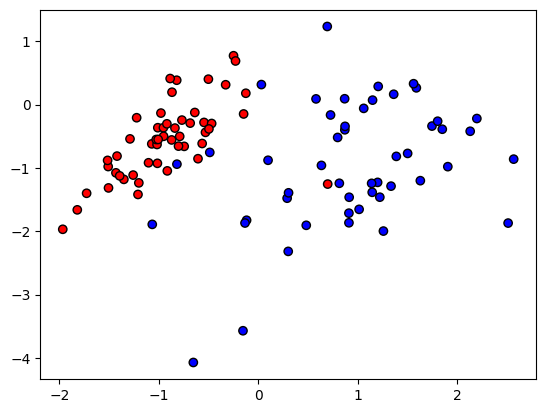

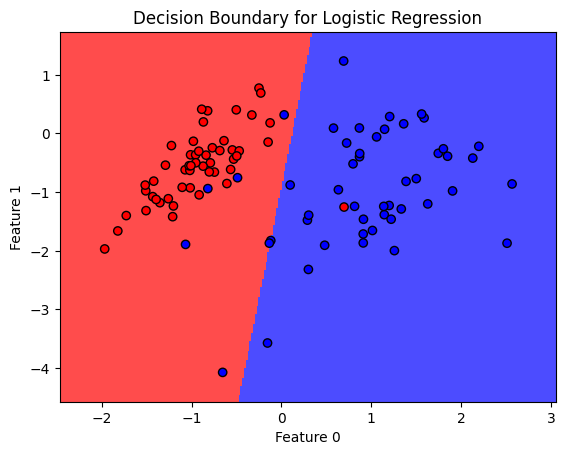

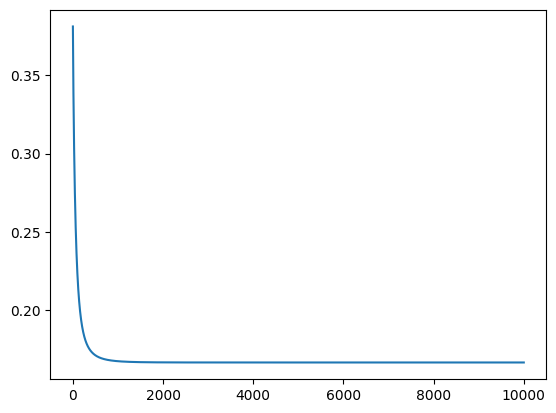

In [29]:
rng = np.random.RandomState(2)
X, y = sk.datasets.make_classification(n_samples=n, n_features=5, n_redundant=2,
                                       n_informative=2, n_repeated=0, n_clusters_per_class=1, random_state=rng)
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split( X, y, test_size=.2, random_state=42)

figure = plt.figure()
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright,edgecolors='k')

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)
print("Taux d'erreur LDA sur l'échantillon de test : ", error_rate(y_test,y_pred_lda))

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)
print("Taux d'erreur Logistic Regression sur l'échantillon de test : ", error_rate(y_test,y_pred_log))
logreg.decision_boundary(X, y)
plt.plot(logreg.loss)

*Comparaison :*\
*En agrandissant les dimensions et en intégrant des variables corrélées, la performance de la Régression Logistique s'améliore de manière significative par rapport à celle de l'Analyse Discriminante Linéaire (LDA). Cette amélioration est due au fait que l'échantillon n'est plus linéairement séparable, ce qui se traduit par un taux d'erreur réduit pour la Régression Logistique.*

## III A vous de jouer (7 pts)
10. Trouver/Générer/Récolter des données adéquates pour l'application d'un algorithme de classification binaire. Décrire ces données (origine, nombre et types de variables, analyse statistique des variables, nombre d'observations, contexte,...) (2pts)
11. Appliquer vos codes de régression logistique et de LDA et reporter les performances obtenues (en apprentissage, en test ou en validation croisées) et commenter (1pts)
12. Trouver une autre méthode à laquelle comparer les deux codes que vous avez développés, décrire (brièvement) le fonctionnement de cette troisème approche et l'appliquer sur les données (de la question 10). On pourra développer soit-même le code ou utiliser une librairie existante. Comparer et discuter les performances obtenues (4pts)

In [30]:
import pandas as pd

# Importation des données
file_path = "./advertising.csv"
data = pd.read_csv(file_path)

# Affichage des 10 premières lignes
data.head(10)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0
5,59.99,23,59761.56,226.74,Sharable client-driven software,Jamieberg,1,Norway,2016-05-19 14:30:17,0
6,88.91,33,53852.85,208.36,Enhanced dedicated support,Brandonstad,0,Myanmar,2016-01-28 20:59:32,0
7,66.00,48,24593.33,131.76,Reactive local challenge,Port Jefferybury,1,Australia,2016-03-07 01:40:15,1
8,74.53,30,68862.00,221.51,Configurable coherent function,West Colin,1,Grenada,2016-04-18 09:33:42,0
9,69.88,20,55642.32,183.82,Mandatory homogeneous architecture,Ramirezton,1,Ghana,2016-07-11 01:42:51,0


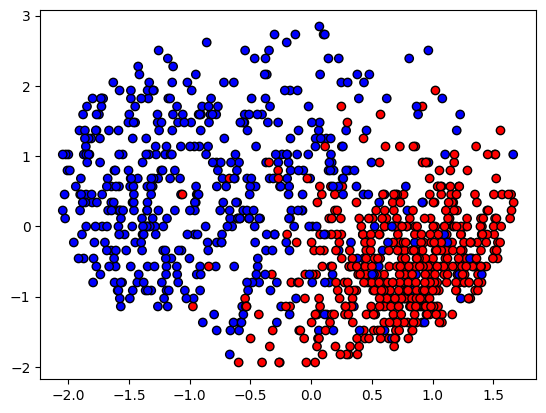

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X = data.drop(['Timestamp', 'Clicked on Ad', 'Ad Topic Line', 'Country', 'City'], axis=1)
y = data['Clicked on Ad']

y = y.to_numpy()

# Normalisation des données
X = scaler.fit_transform(X)

figure = plt.figure()
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright,edgecolors='k')

Taux d'erreur LDA sur l'échantillon de l'apprentissage :  3.38%
Taux d'erreur LDA sur l'échantillon du test :  6.00%
Loss increasing at iteration 6211
Taux d'erreur Logistic Regression sur l'échantillon de l'apprentissage :  2.50%
Taux d'erreur Logistic Regression sur l'échantillon du test :  5.00%


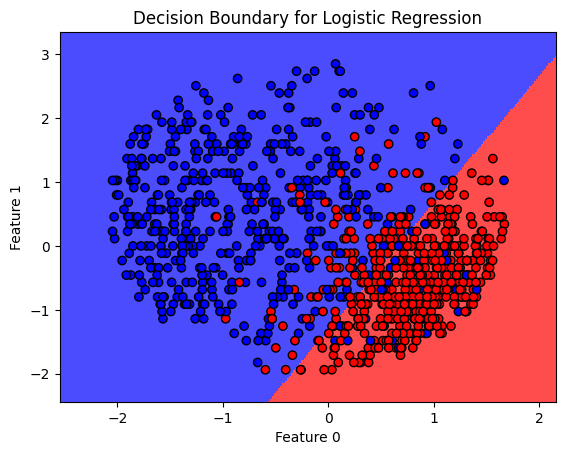

In [33]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=.2, random_state=42)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)
print("Taux d'erreur LDA sur l'échantillon de l'apprentissage : ", lda.error_rate(y_train,X_train))
print("Taux d'erreur LDA sur l'échantillon du test : ", lda.error_rate(y_test,X_test))

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)
print("Taux d'erreur Logistic Regression sur l'échantillon de l'apprentissage : ", logreg.error_rate(y_train,X_train))
print("Taux d'erreur Logistic Regression sur l'échantillon du test : ", logreg.error_rate(y_test,X_test))
logreg.decision_boundary(X, y, feature_pair=(0, 1))

In [35]:
# nous allons utiliser l'approche des machines à vecteurs de support (SVM).
# Cette technique d'apprentissage supervisé consiste à trouver un hyperplan optimal qui sépare les données de différentes classes dans un espace multidimensionnel. Cette hyperplan est choisit comme étant l'hyperplan qui maximise la distance entre l'hyperplan et les échantillons les plus proches de chaque classe.
from sklearn import svm

# Création du modèle SVM
model_svm = svm.SVC(kernel='linear') #On choisit le kernel lineaire car les données sont déja linéairement séparables

# Entrainement du modèle
model_svm.fit(X_train, y_train)

# Prédiction
prediction_svm = model_svm.predict(X_test)
print("Taux d'erreur SVM sur l'échantillon de l'apprentissage : ", (1-model_svm.score(X_train, y_train))*100, "%")
print("Taux d'erreur SVM sur l'échantillon du test : ", (1-model_svm.score(X_test, y_test))*100, "%")

Taux d'erreur SVM sur l'échantillon de l'apprentissage :  2.375000000000005 %
Taux d'erreur SVM sur l'échantillon du test :  4.0000000000000036 %


Commentaire : Nous constatons que le taux d'erreur sur l'échantillon de test avec le modèle SVM est de 4.00%, ce qui est inférieur aux 2 modèles précédents. Cela s'explique par le fait que les données sont tout de même bien séparable entre les deux classes. Et les quelques valeurs aberrantes visibles sur le graphique expliquent le taux d'erreur.